## Issues to address
* price analysis could probably be better
    * prices vary historically; also we have brandnames in original dataset; we could probably just apply the prices to the original dataset
    * used [2017 price list](https://www.cdc.gov/vaccines/programs/vfc/awardees/vaccine-management/price-list/) in below analysis
    * cost of H1N1 was obtained from this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3146485/); [table with cost info](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3146485/table/pone-0022308-t002/ "Title")

## Notes:

* This is just an analysis of those 14 vacs below
* I removed all vaccines from the dataset that are not in that list (e.g. influenza is gone)
* lots of records removed from original df 
    * Number of vaccines removed:  2,414,080
    * Number of IDs removed:  0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [3]:
%%time
df = pd.read_csv("Over_vax_dataset_1+_peds_1.23.17.csv")
df_test = pd.read_csv("Over_vax_dataset_1+_11.30.16.csv")

Wall time: 32.8 s


### Only run this if you want to test this against the old dataset

In [384]:
# run this if you want to see values with old data
df = df_test

In [5]:
# original df specs
original_num_vacs = df.shape[0]
original_num_IDs = df.ID.unique().shape[0]
print("Num of vaccines in original dataset: ", original_num_vacs)
print("Num of IDs in original dataset", original_num_IDs)

Num of vaccines in original dataset:  17773273
Num of IDs in original dataset 568221


In [6]:
group_names = {
  "Diphtheria, Tetanus, Acellular Pertussis" : "DTaP",
  "H1N1-09 Novel Influenza Vaccine" : "H1N1",
  "Hepatitis A" : "HepA",
  "Hepatitis B" : "HepB",
  "Hib" : "Hib",
  "Human papilloma virus vaccine" : "HPV",
  "Influenza" : "Influenza",
  "Meningococcal conjugate" : "MCV4",
  "Measles, Mumps, Rubella" : "MMR",
  "Pneumonia Conjugate" : "PCV",
  "Pneumonia Polysaccharide" : "PPSV",
  "Poliomyelitis" : "Polio",
  "Rotavirus" : "Rotavirus",
  "Varicella" : "Varicella",
  "Zoster vaccine, live" : "Zoster"
}

max_map = { 
  "DTaP"       : 5,
  "H1N1"       : 2,
  "HepA"       : 2,
  "HepB"       : 3,
  "Hib"        : 4,
  "HPV"        : 3,
  "MCV4"       : 2,
  "MMR"        : 2,
  "PCV"        : 4,
  "PPSV"       : 1,
  "Polio"      : 4,
  "Rotavirus"  : 3,
  "Varicella"  : 2,
  "Zoster"     : 1
};

In [8]:
# function that applies above group names to original dataset
def rename_groups(x):
    if x in group_names.keys():
        return group_names[x]
    else:
        return x

In [9]:
# update Vaccine_Group names
df = df.assign(Vaccine_Group = df['Vaccine_Group'].apply(rename_groups))

In [10]:
# list of vaccine groups
vaccine_groups = df['Vaccine_Group'].unique()

# excluded vacs
excluded_vaccines = [vac for vac in vaccine_groups if vac not in max_map.keys()]

# filter df to remove vaccines not in group_names
df = df[~df['Vaccine_Group'].isin(excluded_vaccines)]

# these are total vacs and total ID's
remaining_vacs = df.shape[0]
remaining_IDs = df.ID.unique().shape[0]

print("Number of vaccines removed: ", original_num_vacs - remaining_vacs)
print("Number of IDs removed: ", original_num_IDs - remaining_IDs)

Number of vaccines removed:  2414080
Number of IDs removed:  0


In [11]:
# remove unnecessary columns / keep only valuable columns
df = df[["ID", 'vaccination_date', 'Vaccine_Name', 
         'Vaccine_Group', 'Date_Entered', 'Entered_By', 'AGE_IN_MONTHS']]

In [12]:
# quick check of the dates w/in the dataframe
vac_date_year = df["vaccination_date"].str.slice(-2).astype(int)
enter_date_year = df.Date_Entered.str.slice(-2).astype(int)

# nobody in 2018 in this dataset, which is good
df.groupby([vac_date_year]).agg({"ID" : pd.Series.count})

,ID
vaccination_date,
0,286623
1,345997
2,366212
3,476236
4,579781
5,625913
6,767770
7,1116231
8,1394834


In [13]:
# final year and months in final year
df_final_year = df[vac_date_year == 17]
month_in_final_year = df[vac_date_year == 17].vaccination_date.str.slice(start=0, stop=2).astype(int)

# all 2017 dates are in the month of January, so they look good
df_final_year.groupby(month_in_final_year).agg({'ID' : pd.Series.count})

,ID
vaccination_date,
1,28373


In [39]:
def date_convert(d):
    month, day, year = int(d[:2]), int(d[3:5]), d[6:]
    if int(year) > 90:
        year = int("19" + year)
    else:
        year = int("20" + year)
    vac_date = datetime.date(year, month, day)
    return vac_date

In [86]:
# update vac date and dates entered
vac_dates = df.vaccination_date.map(lambda x: date_convert(x))
dates_entered = df.Date_Entered.map(lambda x: date_convert(x))

df = df.assign(vaccination_date = vac_dates)
df = df.assign(Date_Entered = dates_entered)

In [82]:
# create a years column
years = df.vaccination_date.map(lambda x: x.year)
df['vac_year'] = years

In [19]:
# getting counts of vaccines each individual received
df_vaccine_counts = df.groupby(['ID', 'Vaccine_Group']).count()
df_vaccine_counts = df_vaccine_counts.drop(df_vaccine_counts.columns[:-1], 1)
df_vaccine_counts['Vaccine_Counts'] = df_vaccine_counts.vac_year
df_vaccine_counts.drop('vac_year', 1, inplace=True)
df_vaccine_counts.reset_index(inplace=True)

# add a column of 1's to original df; not really using this right now
df['Vaccine_Count'] = 1

In [49]:
# create a df of only vacs that were given in excess
excessive_vacs_df = df_vaccine_counts[df_vaccine_counts.Vaccine_Counts > 
                  df_vaccine_counts.Vaccine_Group.map(max_map)]

In [50]:
# add a column of the number of excessive vacs given
num_excessive = excessive_vacs_df.Vaccine_Counts - excessive_vacs_df.Vaccine_Group.map(max_map)
excessive_vacs_df = excessive_vacs_df.assign(num_excessive=num_excessive)

In [489]:
%%time
# label vacs as appropriate or not in original df
# this facilitates location analysis and multiple analysis
# takes ~1hr to run
vaccine_groups = list(max_map.keys())
bad_index_list = []

for ID, vacs in df.groupby('ID'):
    vac_groups = vacs.Vaccine_Group.unique()
    bad_indices = []
#     print('\nID:', ID)
    
    for vac_group in vac_groups:
        vac_subgroup = vacs[vacs.Vaccine_Group == vac_group]
        max_len = max_map[vac_group]
        
#         print(vac_group, max_len)
        
        if len(vac_subgroup) > max_len:
            bad_subgroup_indices = list(vac_subgroup[max_len:].index.values)
            bad_indices += bad_subgroup_indices
            
            # print("bad vac:", vac_group, "#bad:", len(vac_subgroup) - max_len)
            # print("bad_subgroup:", bad_subgroup_indices)
            # print("Bad_indices:", bad_indices)
            
        else:
            continue
    
    bad_index_list += bad_indices
    
#     print("final bad indices: ", bad_indices)
#     print("bad_index_list:", bad_index_list)

Wall time: 52min 38s


In [490]:
# save inappropriate indices to a csv file
bad_ind_series = pd.Series(bad_index_list)
bad_ind_series.to_csv("excessive_indices.csv")

In [498]:
# update df by labeling excessive vacs
df.loc[df.index.isin(bad_index_list), 'Excessive'] = True

In [68]:
df_excessive_labels = df[df.Excessive == True]

In [537]:
# add vac counts per ID per vac_group to main df using transform
vacs_per_ID_per_vac_Group = df.groupby(['ID', 'Vaccine_Group'])['Vaccine_Count'].transform(sum)
df = df.assign(vac_counts_per_group=vacs_per_ID_per_vac_Group)

### Save df

In [85]:
df.to_csv("Analyzed_Over_vax_dataset_1+_peds_1.23.17.csv")

## Pivot Table
* didn't really do anything with this, actually

In [21]:
df_vaccine_counts_pivot = df_vaccine_counts.pivot_table(
    df_vaccine_counts, index='ID', columns="Vaccine_Group", aggfunc=np.mean)
df_vaccine_counts_pivot.fillna(value=0, inplace=True)
df_vaccine_counts_pivot.columns = df_vaccine_counts_pivot.columns.get_level_values(1)

### Checkpoint here - just reload data

In [80]:
# Start here
parse_dates = ['vaccination_date', 'Date_Entered']
df = pd.read_csv("Analyzed_Over_vax_dataset_1+_peds_1.23.17.csv", parse_dates=parse_dates, index_col=0)

### Analysis

In [45]:
# total overutilization subpop:
remaining_IDs

568221

In [46]:
# total vacs (of 14 analyzed) administered to analyzed overutilized population
remaining_vacs

# do we want to do all vacs in this dataset or just the 14?

15359193

In [47]:
# number of years included within dataset
(df.vaccination_date.max() - df.vaccination_date.min()).days / 365

18.745205479452054

In [51]:
# Excessive vaccine doses administered
excessive_vacs_df.num_excessive.sum()

870973

In [52]:
# num of excessive vaccines by vaccine group
excessive_vacs_grouped = excessive_vacs_df.groupby(["Vaccine_Group"]).agg({"num_excessive" : np.sum})
excessive_vacs_grouped

,num_excessive
Vaccine_Group,
DTaP,55577
H1N1,3723
HPV,3744
HepA,38762
HepB,384886
Hib,28642
MCV4,2145
MMR,40408
PCV,115333


In [53]:
# cost estimates using vaccine price list
vaccine_costs = pd.read_excel("vaccine_costs.xlsx", converters={"Vaccine_Group":str, 'Price':float}, index_col="Vaccine_Group")
excessive_vac_costs = pd.merge(excessive_vacs_grouped, vaccine_costs, how="left", left_index=True, right_index=True)
excessive_vac_costs['total_cost_per_vac_group'] = excessive_vac_costs.num_excessive * excessive_vac_costs.Price
excessive_vac_costs

,num_excessive,Price,total_cost_per_vac_group
Vaccine_Group,,,
DTaP,55577,23.603333,1.311802e+06
H1N1,3723,19.900000,7.408770e+04
HPV,3744,155.540000,5.823418e+05
HepA,38762,63.875000,2.475923e+06
HepB,384886,56.327500,2.167967e+07
Hib,28642,26.235000,7.514229e+05
MCV4,2145,133.519600,2.863995e+05
MMR,40408,62.790000,2.537218e+06
PCV,115333,159.570000,1.840369e+07


In [54]:
# total estimated cost
float("{:.2f}".format(excessive_vac_costs.total_cost_per_vac_group.sum()))

57093387.83

In [55]:
# Pattern of Vaccine Overutilization
excessive_vacs_df.groupby("num_excessive").agg({"Vaccine_Counts" : "count"})

,Vaccine_Counts
num_excessive,
1,735561
2,48027
3,8793
4,2072
5,555
6,164
7,62
8,28
9,6


In [57]:
def multiple_in_excess_finder(mult):
    return excessive_vacs_df[excessive_vacs_df.Vaccine_Counts >= mult * excessive_vacs_df.Vaccine_Group.map(max_map)]

In [58]:
# Individuals Receiving >= 2x ACIP-Recommended Doses of Multiple Vaccine Series
IDs_with_2x_excess = multiple_in_excess_finder(2)
IDs_with_2x_excess_grouped = IDs_with_2x_excess.groupby('ID').agg({'Vaccine_Group' : 'count'})
IDs_2x = IDs_with_2x_excess_grouped.index.values
IDs_wo_2x_count = df[~df.ID.isin(IDs_2x)]
zero_counts = IDs_wo_2x_count.ID.nunique()
value_counts_of_2x_in_excess = IDs_with_2x_excess_grouped.Vaccine_Group.value_counts()
value_counts_of_2x_in_excess.set_value(0, zero_counts)
value_counts_of_2x_in_excess = value_counts_of_2x_in_excess.sort_index()
value_counts_of_2x_in_excess

0     554114
1      12770
2        850
3        199
4        141
5         72
6         41
7         20
8         11
9          2
10         1
Name: Vaccine_Group, dtype: int64

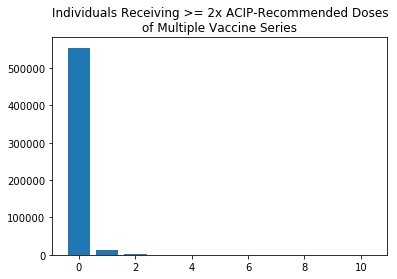

In [663]:
plt.bar(left=value_counts_of_2x_in_excess.index, height=value_counts_of_2x_in_excess.values)
plt.title("Individuals Receiving >= 2x ACIP-Recommended Doses\nof Multiple Vaccine Series")
plt.show()

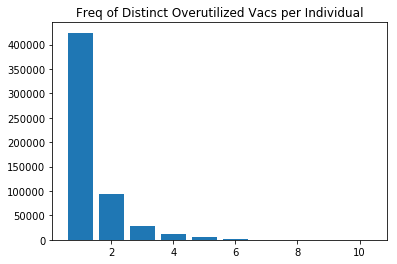

1     424287
2      94450
3      28426
4      12351
5       5929
6       1984
7        555
8        171
9         63
10         5
Name: Vaccine_Group, dtype: int64

In [59]:
# Frequenty of Distinct Overutilized Vaccines per Individual
num_excessive_vac_series = excessive_vacs_df.groupby(
    ['ID']).agg({"Vaccine_Group" : "count"}
               ).Vaccine_Group.value_counts().sort_index()

plt.bar(left=num_excessive_vac_series.index, 
        height=num_excessive_vac_series.values)

plt.title("Freq of Distinct Overutilized Vacs per Individual")
plt.show()
num_excessive_vac_series

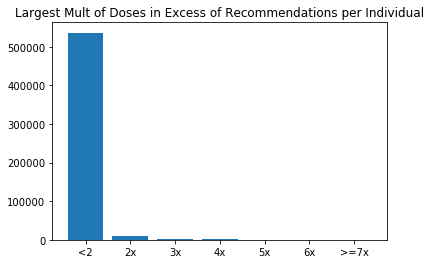

In [662]:
# multiples of dosing for one vaccine series
mults = [IDs_wo_2x_count.ID.nunique()]
for x in range(2, 8):
    ID_count = multiple_in_excess_finder(x).ID.nunique()
    mults.append(ID_count)

# this it so you don't double count the values from later multiples in previous multiples
for ind, mult in enumerate(mults):
    mults[ind] = mult - sum(mults[ind+1:])

# you will need to recreate labels if this goes awry
labels = ["<2", "2x", "3x", "4x", "5x", "6x", ">=7x"]
len(labels) == len(mults)

plt.bar(height=mults, left=range(0,7))
plt.xticks(range(0,7), labels, rotation=0)
plt.title("Largest Mult of Doses in Excess of Recommendations per Individual")
plt.show()

In [60]:
clinics_with_excess_vacs = df[df.Excessive == True].groupby("Entered_By").agg(
    {"Vaccine_Count" : np.sum}).sort_values("Vaccine_Count", ascending=False)
excess_vac_total = clinics_with_excess_vacs.Vaccine_Count.sum()

In [98]:
# percentage of inapp vacs top 10 clinics administered
clinics_with_excess_vacs[:10].Vaccine_Count.sum() / clinics_with_excess_vacs.Vaccine_Count.sum() * 100

25.416631744037986

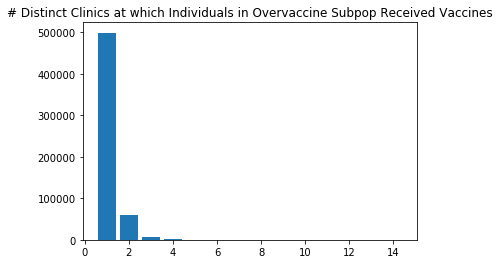

1     499386
2      59931
3       7744
4       1000
5        132
6         22
7          3
8          2
14         1
Name: Entered_By, dtype: int64

In [101]:
num_unique_clinics_df = df[df.Excessive == True].groupby(['ID']).agg({ "Entered_By" : pd.Series.nunique})
num_unique_clinics_value_counts = num_unique_clinics_df.Entered_By.value_counts().sort_index()
plt.bar(left=num_unique_clinics_value_counts.index, height=num_unique_clinics_value_counts.values)
plt.title("# Distinct Clinics at which Individuals in Overvaccine Subpop Received Vaccines")
plt.show()
num_unique_clinics_value_counts

In [75]:
excess_per_year = df_excessive_labels[['Vaccine_Group', 'Vaccine_Count', 'vac_year']]

In [87]:
# num excessive of each vaccine by year
excess_per_year_pivot = excess_per_year.pivot_table(
    index="vac_year", columns="Vaccine_Group", aggfunc=np.sum)
excess_per_year_pivot.fillna(0, inplace=True)
excess_per_year_pivot

Vaccine_Count                                                 \
Vaccine_Group          DTaP    H1N1    HPV    HepA     HepB     Hib   MCV4   
vac_year                                                                     
1998                  570.0     0.0    2.0    37.0   1923.0   397.0    2.0   
1999                 2098.0     1.0   10.0   116.0   5095.0  1432.0   20.0   
2000                 2915.0     3.0   11.0   154.0   6332.0  1637.0   23.0   
2001                 3435.0     5.0   16.0   221.0   7477.0  1526.0   40.0   
2002                 3641.0    20.0   23.0   267.0   8584.0  1474.0   36.0   
2003                 4286.0    47.0   10.0   294.0  14800.0  1836.0   42.0   
2004                 4700.0    44.0   11.0   452.0  20796.0  1780.0   48.0   
2005                 4873.0    74.0    5.0   423.0  21644.0  1647.0   67.0   
2006                 4679.0    92.0    4.0  1800.0  24440.0  1377.0   64.0   
2007                 4359.0   159.0   12.0  4222.0  30731.0  1239.0   74.0   
2008                 3967.0   197.0   26.0  4728.0  35057.0  1866.0   97.0   
2009                 3616.0  1708.0   63.0  4347.0  22892.0  2500.0  124.0   
2010                 3423.0   900.0  181.0  4099.0  20768.0  2527.0  190.0   
2011                 3164.0   184.0  336.0  4057.0  21426.0  2052.0  220.0   
2012                 2272.0   135.0  606.0  3754.0  25907.0  1768.0  189.0   
2013                 1408.0   105.0  671.0  3300.0  32561.0  1447.0  154.0   
2014                  943.0    32.0  730.0  2962.0  29807.0  1156.0  183.0   
2015                  701.0    15.0  627.0  2178.0  31676.0   725.0  208.0   
2016                  505.0     2.0  391.0  1317.0  22524.0   248.0  351.0   
2017                   22.0     0.0    9.0    34.0    446.0     8.0   13.0   

                                                                           
Vaccine_Group     MMR      PCV   PPSV    Polio Rotavirus Varicella Zoster  
vac_year                                                                   
1998             80.0      4.0    2.0   1179.0      12.0      19.0    0.0  
1999            750.0      6.0    9.0   3927.0      38.0     456.0    3.0  
2000           1615.0    476.0  367.0   4809.0       2.0     991.0    6.0  
2001           1826.0   1278.0  943.0   5057.0       6.0    1219.0    4.0  
2002           2035.0   1754.0  692.0   5272.0       3.0    1304.0    2.0  
2003           2593.0   2341.0  759.0   6312.0       4.0    1759.0    7.0  
2004           3209.0   2707.0  622.0   7055.0       2.0    1790.0    4.0  
2005           3421.0   4410.0  633.0   7290.0       6.0    1382.0    2.0  
2006           3287.0   9084.0  533.0   7079.0      77.0    1859.0    6.0  
2007           2889.0  17817.0  424.0   6726.0     461.0    3316.0    9.0  
2008           2676.0  24714.0  433.0  11231.0     657.0    3092.0   10.0  
2009           2529.0  18871.0  400.0  17641.0     542.0    2853.0    9.0  
2010           2743.0  16392.0  287.0  19943.0     494.0    2559.0    4.0  
2011           3019.0   7929.0  224.0  17595.0     382.0    2502.0    7.0  
2012           2167.0   3065.0  196.0  10059.0     364.0    2229.0    7.0  
2013           1906.0   1904.0  145.0   7129.0     307.0    1660.0    1.0  
2014           1510.0   1320.0  102.0   6872.0     274.0    1342.0    2.0  
2015           1275.0    905.0   66.0   5661.0     179.0     961.0    1.0  
2016            849.0    343.0   55.0   3960.0     120.0     613.0    1.0  
2017             29.0     13.0    2.0    118.0       3.0      20.0    0.0

In [111]:
# value counts of the num of excessive vaccines individuals received
excess_vac_cnts = df_excessive_labels.groupby(['ID']).agg({'Vaccine_Count' : np.sum})
excess_vac_value_counts = excess_vac_cnts['Vaccine_Count'].value_counts().sort_index()
excess_vacs_value_counts

1     407493
2      96151
3      32544
4      14931
5       7850
6       3992
7       1953
8       1039
9        665
10       372
11       277
12       188
13       122
14       112
15        87
16        74
17        60
18        52
19        39
20        36
21        43
22        23
23        41
24        14
25        12
26        14
27         8
28         8
29         5
30         2
32         3
34         1
35         2
36         1
38         1
40         1
44         1
47         1
52         1
57         1
58         1
Name: Vaccine_Count, dtype: int64